# 📊 Data Collector — Демонстрация работы

Этот notebook демонстрирует работу модуля `scripts/data_collector.py` для сбора и обработки финансовых данных.

## Содержание

1. [Введение и архитектура](#1-введение)
2. [Настройка окружения](#2-настройка)
3. [Загрузка и просмотр данных](#3-загрузка-данных)
4. [Анализ структуры данных](#4-анализ-структуры)
5. [Визуализация](#5-визуализация)
6. [Работа с индикаторами](#6-индикаторы)
7. [Использование компонентов](#7-компоненты)

---

## 1. Введение <a id="1-введение"></a>

### Что делает Data Collector?

Скрипт `data_collector.py` автоматизирует процесс:

- 📥 **Загрузки исторических свечей** (OHLCV) через API Tinkoff Invest
- 📈 **Расчёта 30+ технических индикаторов** (тренд, осцилляторы, волатильность)
- 🔄 **Инкрементального обновления** — загружает только новые данные
- 💾 **Сохранения в Parquet** — эффективный сжатый формат

### Архитектура

```
┌─────────────────────────────────────────────────────────────────┐
│                        DataCollector                            │
│                    (главный оркестратор)                        │
├─────────────────────────────────────────────────────────────────┤
│  ┌──────────────────┐  ┌──────────────────┐  ┌────────────────┐│
│  │ DataCollector    │  │ CandleDataLoader │  │ DataFileManager││
│  │ Config           │  │ (API + retry)    │  │ (Parquet I/O)  ││
│  └──────────────────┘  └──────────────────┘  └────────────────┘│
│  ┌──────────────────┐  ┌──────────────────┐                    │
│  │ Indicator        │  │ DataFrame        │                    │
│  │ Calculator       │  │ Cleaner          │                    │
│  └──────────────────┘  └──────────────────┘                    │
└─────────────────────────────────────────────────────────────────┘
```

---

## 2. Настройка окружения <a id="2-настройка"></a>

In [1]:
# === ИМПОРТЫ ===
import sys
from pathlib import Path

# Добавляем корень проекта в путь для импорта модулей
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Стандартные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

# Модули проекта
from scripts.data_collector import (
    DataCollectorConfig,
    IndicatorCalculator,
    DataFileManager,
    DataFrameCleaner,
    TrendIndicators,
    OscillatorIndicators,
    VolatilityIndicators,
    VolumeIndicators,
    PatternIndicators,
    RegimeIndicators,
)
import settings

# Настройки отображения
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Импорты загружены успешно!")
print(f"📁 Корень проекта: {PROJECT_ROOT}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
✅ Импорты загружены успешно!
📁 Корень проекта: /Users/denis/dev/app/dss_backend


In [2]:
# === КОНФИГУРАЦИЯ ===

# Путь к данным
DATA_DIR = PROJECT_ROOT / "data" / "tickers"

# Доступные таймфреймы
TIMEFRAMES = ["M5", "M15", "M30", "H1", "H2", "H4", "D1", "Week"]

# Получаем список доступных тикеров
available_tickers = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])

print(f"📊 Найдено тикеров: {len(available_tickers)}")
print(f"📈 Доступные таймфреймы: {TIMEFRAMES}")
print(f"\n🏷️ Тикеры: {', '.join(available_tickers[:10])}...")

📊 Найдено тикеров: 44
📈 Доступные таймфреймы: ['M5', 'M15', 'M30', 'H1', 'H2', 'H4', 'D1', 'Week']

🏷️ Тикеры: AFKS, AFLT, ALRS, ASTR, BSPB, CBOM, CHMF, ENPG, FEES, FLOT...


---

## 3. Загрузка и просмотр данных <a id="3-загрузка-данных"></a>

In [3]:
def load_ticker_data(ticker: str, timeframe: str = "H1") -> pd.DataFrame:
    """
    Загружает данные тикера из Parquet файла.
    
    Args:
        ticker: Тикер инструмента (например, 'SBER')
        timeframe: Таймфрейм (M5, M15, M30, H1, H2, H4, D1, Week)
    
    Returns:
        DataFrame с данными и индикаторами
    """
    file_path = DATA_DIR / ticker / f"{timeframe}.parquet"
    
    if not file_path.exists():
        raise FileNotFoundError(f"Файл не найден: {file_path}")
    
    df = pd.read_parquet(file_path)
    return df.sort_index()


# Загружаем данные для примера
TICKER = "SBER"  # Можете изменить на любой доступный тикер
TIMEFRAME = "H1"

df = load_ticker_data(TICKER, TIMEFRAME)

print(f"📈 Загружены данные: {TICKER} ({TIMEFRAME})")
print(f"📅 Период: {df.index.min()} — {df.index.max()}")
print(f"📊 Строк: {len(df):,}")
print(f"📋 Столбцов: {len(df.columns)}")

📈 Загружены данные: SBER (H1)
📅 Период: 2025-02-26 09:00:00+00:00 — 2025-12-11 17:00:00+00:00
📊 Строк: 3,772
📋 Столбцов: 38


In [4]:
# === ПРОСМОТР ПЕРВЫХ СТРОК ===
print("🔍 Первые 5 строк данных:")
df.head()

🔍 Первые 5 строк данных:


,open,high,low,close,volume,sma5,sma10,sma20,sma50,ema10,ema20,ema50,ema200,macd,macd_signal,macd_hist,rsi,stoch_k,stoch_d,cci,willr,atr,bb_lower,bb_middle,bb_upper,bb_pband,vol_roc,vol_sma20,vol_rel,pat_doji,pat_hammer,pat_engulfing,atr_sma50,regime_vol,adx,regime_trend,regime_liq,market_regime
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-26 09:00:00+00:00,316.14,316.50,315.08,315.23,3002770,316.148,316.570,316.6865,315.7284,316.311843,316.389974,315.962448,311.806200,0.043782,0.266149,-0.222366,39.634677,20.650420,27.785996,-48434.891716,-93.670886,0.904738,315.611105,316.6865,317.761895,-0.177193,-0.090048,1801698.0,1.666633,0.0,0,0,1.127441,0,21.341945,0,1,1
2025-02-26 10:00:00+00:00,315.24,315.64,311.33,312.12,10186790,315.158,316.101,316.4485,315.6884,315.549690,315.983310,315.811763,311.809322,-0.298110,0.153297,-0.451407,24.797433,18.218092,22.369560,-30773.944256,-87.091503,1.147971,314.146288,316.4485,318.750712,-0.440074,2.392464,2163028.0,4.709504,0.0,0,0,1.123353,1,23.921490,0,1,101
2025-02-26 11:00:00+00:00,312.12,313.05,310.44,312.18,8422900,314.302,315.621,316.1980,315.6430,314.937019,315.621090,315.669341,311.813011,-0.557791,0.011079,-0.568870,25.377825,14.686431,17.851648,-19498.274214,-75.178317,1.252402,313.238942,316.1980,319.157058,-0.178932,-0.173155,2458354.5,3.426235,1.0,0,0,1.122070,1,26.617211,1,1,111
2025-02-26 12:00:00+00:00,312.17,313.44,309.40,310.04,9125120,313.138,314.928,315.8625,315.5472,314.046652,315.089557,315.448583,311.795369,-0.925600,-0.176256,-0.749343,19.575019,15.226830,16.043785,-13248.993232,-92.049689,1.451516,311.837416,315.8625,319.887584,-0.223277,0.083370,2795269.5,3.264487,0.0,0,0,1.125508,1,29.423375,1,1,111
2025-02-26 13:00:00+00:00,310.06,311.60,308.31,311.40,8983460,312.194,314.371,315.5575,315.4764,313.565442,314.738171,315.289815,311.791435,-1.094731,-0.359951,-0.734780,30.457844,22.193145,17.368802,-9964.504837,-66.192560,1.582836,311.148701,315.5575,319.966299,0.028500,-0.015524,3055350.5,2.940239,0.0,0,0,1.132486,1,32.299484,1,1,111


In [5]:
# === ПРОСМОТР ПОСЛЕДНИХ СТРОК ===
print("🔍 Последние 5 строк данных:")
df.tail()

🔍 Последние 5 строк данных:


,open,high,low,close,volume,sma5,sma10,sma20,sma50,ema10,ema20,ema50,ema200,macd,macd_signal,macd_hist,rsi,stoch_k,stoch_d,cci,willr,atr,bb_lower,bb_middle,bb_upper,bb_pband,vol_roc,vol_sma20,vol_rel,pat_doji,pat_hammer,pat_engulfing,atr_sma50,regime_vol,adx,regime_trend,regime_liq,market_regime
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-11 13:00:00+00:00,307.99,308.05,307.45,307.86,1351421,307.984,307.653,307.1135,306.4616,307.665918,307.306204,306.661263,304.902479,0.432352,0.351555,0.080797,58.343692,49.333333,52.069512,-32009.230501,-51.666667,0.715767,305.603724,307.1135,308.623276,0.747222,-0.156884,1385489.30,0.975411,0.0,0,0,0.815485,0,18.369486,0,0,0
2025-12-11 14:00:00+00:00,307.86,308.59,307.10,307.14,2088840,307.720,307.671,307.1425,306.5086,307.570297,307.290375,306.680037,304.924743,0.365145,0.354273,0.010872,50.147062,41.436937,46.987396,-34081.922561,-76.689189,0.771070,305.655378,307.1425,308.629622,0.499159,0.545662,1463487.20,1.427303,0.0,0,0,0.811651,0,18.878001,0,1,1
2025-12-11 15:00:00+00:00,307.14,307.66,305.20,306.19,7218199,307.400,307.591,307.1270,306.5266,307.319334,307.185577,306.660820,304.937332,0.232545,0.329927,-0.097383,41.802244,31.719861,40.830044,-33184.908106,-76.484561,0.891708,305.605614,307.1270,308.648386,0.192057,2.455602,1781542.85,4.051656,0.0,0,0,0.810547,1,18.165393,0,1,101
2025-12-11 16:00:00+00:00,306.20,309.19,306.18,308.01,6839788,307.438,307.722,307.2195,306.5878,307.444909,307.264094,306.713729,304.967906,0.271191,0.318180,-0.046989,56.676299,37.857364,37.004721,-35205.649998,-33.254157,1.043014,305.720876,307.2195,308.718124,0.763742,-0.052425,2067871.75,3.307646,0.0,0,0,0.812565,1,17.725724,0,1,101
2025-12-11 17:00:00+00:00,308.00,308.17,307.62,307.79,337530,307.398,307.798,307.2725,306.6436,307.507653,307.314180,306.755936,304.995987,0.280829,0.310710,-0.029881,54.851367,50.593824,40.057017,-37827.518841,-38.479810,1.007799,305.771793,307.2725,308.773207,0.672419,-0.950652,2048162.65,0.164796,0.0,0,0,0.815153,1,17.317460,0,0,100


---

## 4. Анализ структуры данных <a id="4-анализ-структуры"></a>

In [6]:
# === ГРУППИРОВКА СТОЛБЦОВ ПО КАТЕГОРИЯМ ===

# Базовые столбцы OHLCV
base_cols = ["open", "high", "low", "close", "volume"]

# Трендовые индикаторы
trend_cols = [c for c in df.columns if c.startswith(('sma', 'ema', 'macd'))]

# Осцилляторы
oscillator_cols = [c for c in df.columns if c in ['rsi', 'stoch_k', 'stoch_d', 'cci', 'willr']]

# Волатильность
volatility_cols = [c for c in df.columns if c.startswith(('atr', 'bb_'))]

# Объём
volume_cols = [c for c in df.columns if c.startswith('vol_')]

# Паттерны
pattern_cols = [c for c in df.columns if c.startswith('pat_')]

# Режим рынка
regime_cols = [c for c in df.columns if c.startswith('regime') or c in ['adx', 'market_regime', 'atr_sma50']]

print("📋 СТРУКТУРА ДАННЫХ\n")
print(f"🔹 Базовые (OHLCV):     {len(base_cols)} столбцов")
print(f"   {base_cols}\n")
print(f"🔹 Трендовые:           {len(trend_cols)} столбцов")
print(f"   {trend_cols}\n")
print(f"🔹 Осцилляторы:         {len(oscillator_cols)} столбцов")
print(f"   {oscillator_cols}\n")
print(f"🔹 Волатильность:       {len(volatility_cols)} столбцов")
print(f"   {volatility_cols}\n")
print(f"🔹 Объём:               {len(volume_cols)} столбцов")
print(f"   {volume_cols}\n")
print(f"🔹 Паттерны:            {len(pattern_cols)} столбцов")
print(f"   {pattern_cols}\n")
print(f"🔹 Режим рынка:         {len(regime_cols)} столбцов")
print(f"   {regime_cols}")

📋 СТРУКТУРА ДАННЫХ

🔹 Базовые (OHLCV):     5 столбцов
   ['open', 'high', 'low', 'close', 'volume']

🔹 Трендовые:           11 столбцов
   ['sma5', 'sma10', 'sma20', 'sma50', 'ema10', 'ema20', 'ema50', 'ema200', 'macd', 'macd_signal', 'macd_hist']

🔹 Осцилляторы:         5 столбцов
   ['rsi', 'stoch_k', 'stoch_d', 'cci', 'willr']

🔹 Волатильность:       6 столбцов
   ['atr', 'bb_lower', 'bb_middle', 'bb_upper', 'bb_pband', 'atr_sma50']

🔹 Объём:               3 столбцов
   ['vol_roc', 'vol_sma20', 'vol_rel']

🔹 Паттерны:            3 столбцов
   ['pat_doji', 'pat_hammer', 'pat_engulfing']

🔹 Режим рынка:         6 столбцов
   ['atr_sma50', 'regime_vol', 'adx', 'regime_trend', 'regime_liq', 'market_regime']


In [7]:
# === СТАТИСТИКА ПО ОСНОВНЫМ СТОЛБЦАМ ===
print("📊 Статистика по OHLCV и ключевым индикаторам:")
key_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'adx']
df[key_cols].describe().round(2)

📊 Статистика по OHLCV и ключевым индикаторам:


,open,high,low,close,volume,rsi,atr,adx
count,3772.00,3772.00,3772.00,3772.00,3772.00,3772.00,3772.00,3772.00
mean,306.15,306.77,305.46,306.13,1973642.57,50.02,1.36,25.81
std,9.92,9.82,10.01,9.90,2551269.39,11.64,0.52,10.03
min,278.42,280.91,275.76,278.44,305.00,15.21,0.55,9.23
25%,300.39,301.19,299.79,300.40,537983.50,41.83,0.97,17.88
50%,307.38,307.94,306.70,307.35,1261691.50,49.95,1.26,24.25
75%,313.04,313.48,312.51,313.03,2479595.00,58.45,1.61,32.54
max,332.48,332.48,327.82,329.10,48630870.00,86.04,4.35,64.50


In [8]:
# === ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ ===
print("🔍 Типы данных и память:")
df.info(memory_usage='deep')

🔍 Типы данных и память:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3772 entries, 2025-02-26 09:00:00+00:00 to 2025-12-11 17:00:00+00:00
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           3772 non-null   float64
 1   high           3772 non-null   float64
 2   low            3772 non-null   float64
 3   close          3772 non-null   float64
 4   volume         3772 non-null   int64  
 5   sma5           3772 non-null   float64
 6   sma10          3772 non-null   float64
 7   sma20          3772 non-null   float64
 8   sma50          3772 non-null   float64
 9   ema10          3772 non-null   float64
 10  ema20          3772 non-null   float64
 11  ema50          3772 non-null   float64
 12  ema200         3772 non-null   float64
 13  macd           3772 non-null   float64
 14  macd_signal    3772 non-null   float64
 15  macd_hist      3772 non-null   float64
 16  rsi            3772 non-

---

## 5. Визуализация <a id="5-визуализация"></a>

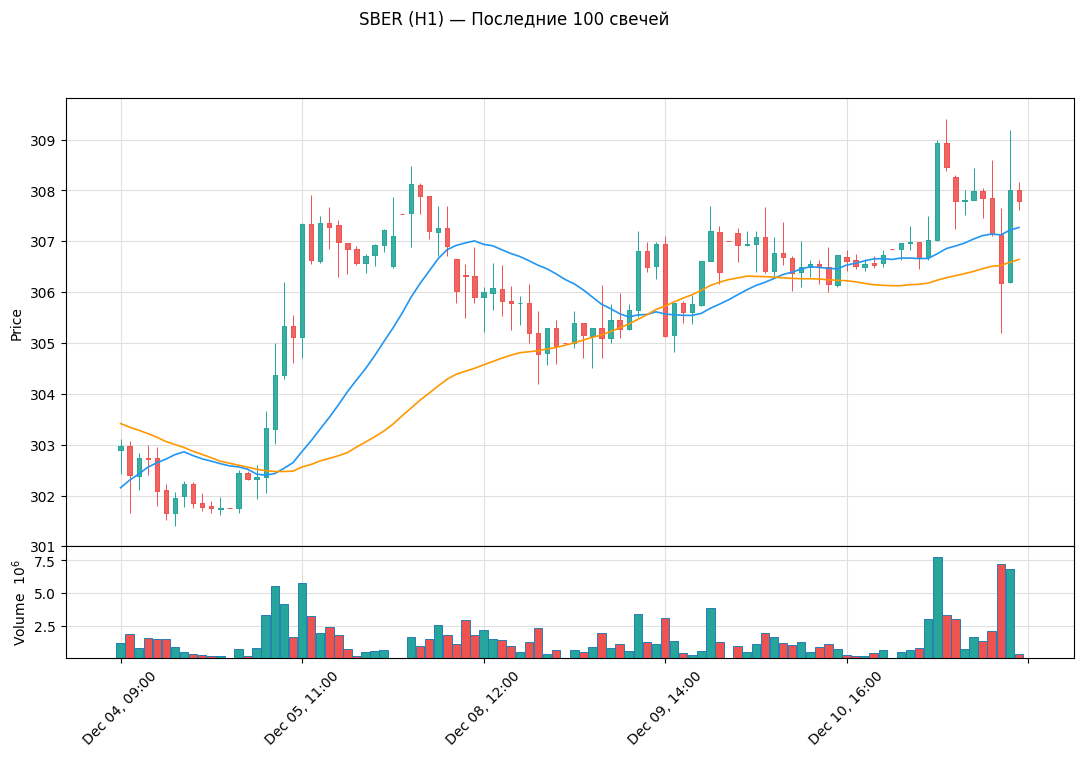

In [9]:
# === СВЕЧНОЙ ГРАФИК ===

# Берём последние N свечей для визуализации
N_CANDLES = 100
df_plot = df.tail(N_CANDLES).copy()

# Подготавливаем данные для mplfinance
df_ohlcv = df_plot[['open', 'high', 'low', 'close', 'volume']].copy()
df_ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Создаём кастомный стиль
mc = mpf.make_marketcolors(
    up='#26a69a',
    down='#ef5350',
    edge='inherit',
    wick='inherit',
    volume='inherit'
)
style = mpf.make_mpf_style(marketcolors=mc, gridstyle='-', gridcolor='#e0e0e0')

# Добавляем скользящие средние
addplots = []
if 'sma20' in df_plot.columns:
    addplots.append(mpf.make_addplot(df_plot['sma20'], color='#2196f3', width=1.2))
if 'sma50' in df_plot.columns:
    addplots.append(mpf.make_addplot(df_plot['sma50'], color='#ff9800', width=1.2))

# Строим график
fig, axes = mpf.plot(
    df_ohlcv,
    type='candle',
    style=style,
    title=f'{TICKER} ({TIMEFRAME}) — Последние {N_CANDLES} свечей',
    volume=True,
    addplot=addplots if addplots else None,
    figsize=(14, 8),
    returnfig=True,
    panel_ratios=(4, 1)
)
plt.show()

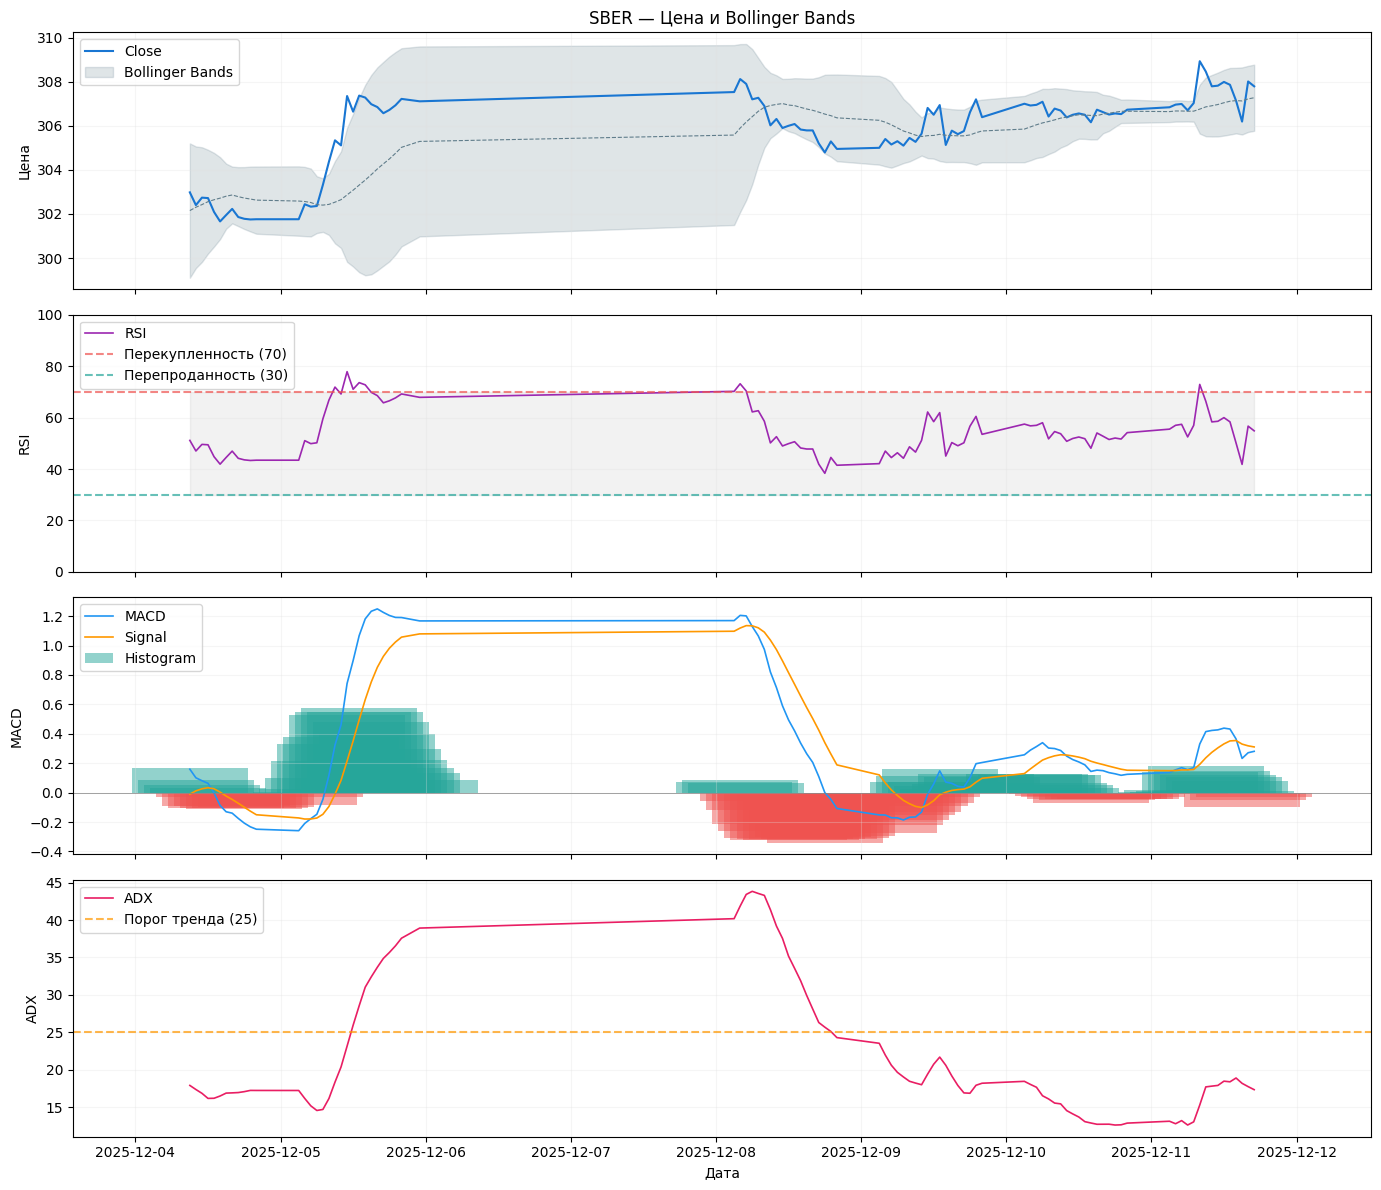

In [10]:
# === ГРАФИК ИНДИКАТОРОВ ===

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Цена закрытия с Bollinger Bands
ax1 = axes[0]
ax1.plot(df_plot.index, df_plot['close'], label='Close', color='#1976d2', linewidth=1.5)
if 'bb_upper' in df_plot.columns:
    ax1.fill_between(df_plot.index, df_plot['bb_lower'], df_plot['bb_upper'], 
                     alpha=0.2, color='#607d8b', label='Bollinger Bands')
    ax1.plot(df_plot.index, df_plot['bb_middle'], color='#607d8b', linestyle='--', linewidth=0.8)
ax1.set_ylabel('Цена')
ax1.set_title(f'{TICKER} — Цена и Bollinger Bands')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. RSI
ax2 = axes[1]
ax2.plot(df_plot.index, df_plot['rsi'], label='RSI', color='#9c27b0', linewidth=1.2)
ax2.axhline(y=70, color='#ef5350', linestyle='--', alpha=0.7, label='Перекупленность (70)')
ax2.axhline(y=30, color='#26a69a', linestyle='--', alpha=0.7, label='Перепроданность (30)')
ax2.fill_between(df_plot.index, 30, 70, alpha=0.1, color='gray')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. MACD
ax3 = axes[2]
if 'macd' in df_plot.columns:
    ax3.plot(df_plot.index, df_plot['macd'], label='MACD', color='#2196f3', linewidth=1.2)
    ax3.plot(df_plot.index, df_plot['macd_signal'], label='Signal', color='#ff9800', linewidth=1.2)
    colors = ['#26a69a' if v >= 0 else '#ef5350' for v in df_plot['macd_hist']]
    ax3.bar(df_plot.index, df_plot['macd_hist'], color=colors, alpha=0.5, label='Histogram')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.set_ylabel('MACD')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. ADX
ax4 = axes[3]
if 'adx' in df_plot.columns:
    ax4.plot(df_plot.index, df_plot['adx'], label='ADX', color='#e91e63', linewidth=1.2)
    ax4.axhline(y=25, color='#ff9800', linestyle='--', alpha=0.7, label='Порог тренда (25)')
ax4.set_ylabel('ADX')
ax4.set_xlabel('Дата')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

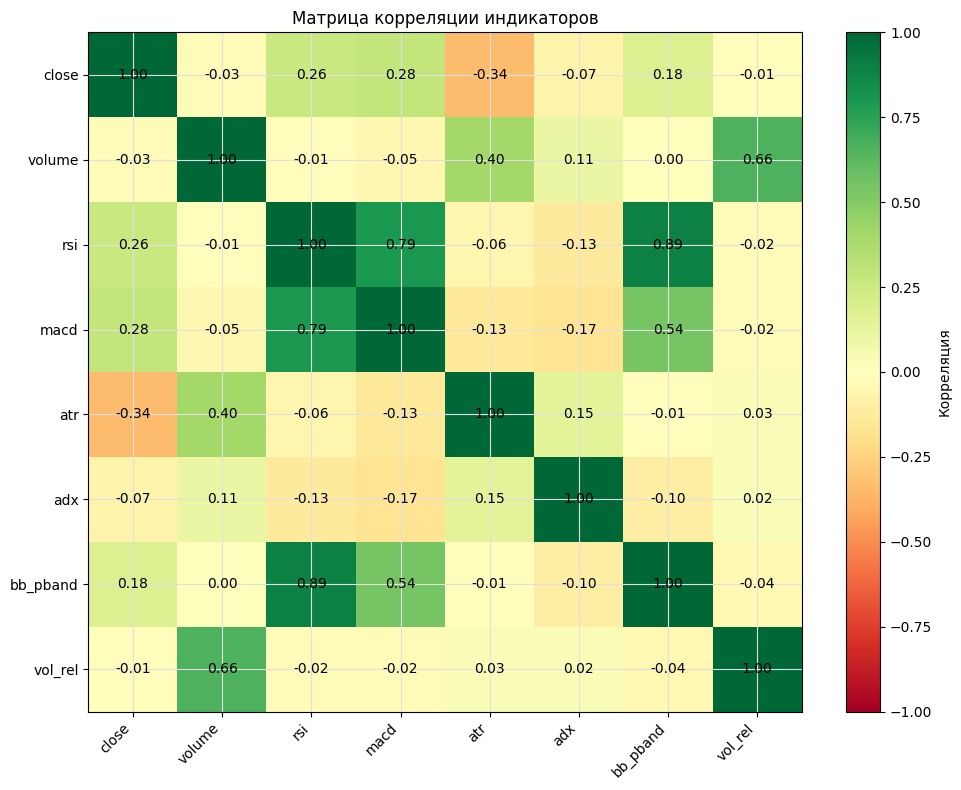

In [11]:
# === КОРРЕЛЯЦИЯ ИНДИКАТОРОВ ===

# Выбираем ключевые индикаторы для анализа корреляции
corr_cols = ['close', 'volume', 'rsi', 'macd', 'atr', 'adx', 'bb_pband', 'vol_rel']
corr_cols = [c for c in corr_cols if c in df.columns]

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Подписи
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha='right')
ax.set_yticklabels(corr_cols)

# Значения в ячейках
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=10)

plt.colorbar(im, label='Корреляция')
plt.title('Матрица корреляции индикаторов')
plt.tight_layout()
plt.show()

---

## 6. Работа с индикаторами <a id="6-индикаторы"></a>

In [12]:
# === АНАЛИЗ РЫНОЧНОГО РЕЖИМА ===

print("📊 АНАЛИЗ РЫНОЧНОГО РЕЖИМА\n")

# Подсчёт режимов
if 'market_regime' in df.columns:
    regime_counts = df['market_regime'].value_counts().sort_index()
    
    print("Распределение режимов рынка (код XYZ):")
    print("  X - волатильность (0=низкая, 1=высокая)")
    print("  Y - тренд (0=боковой, 1=трендовый)")
    print("  Z - ликвидность (0=низкая, 1=высокая)\n")
    
    for regime, count in regime_counts.items():
        pct = count / len(df) * 100
        vol = "Высокая" if regime >= 100 else "Низкая"
        trend = "Тренд" if (regime % 100) >= 10 else "Боковой"
        liq = "Высокая" if (regime % 10) >= 1 else "Низкая"
        print(f"  Режим {int(regime):03d}: {count:,} ({pct:.1f}%) — Вол: {vol}, {trend}, Лик: {liq}")

# Текущий режим
if 'market_regime' in df.columns:
    current_regime = int(df['market_regime'].iloc[-1])
    print(f"\n🎯 Текущий режим рынка: {current_regime:03d}")

📊 АНАЛИЗ РЫНОЧНОГО РЕЖИМА

Распределение режимов рынка (код XYZ):
  X - волатильность (0=низкая, 1=высокая)
  Y - тренд (0=боковой, 1=трендовый)
  Z - ликвидность (0=низкая, 1=высокая)

  Режим 000: 911 (24.2%) — Вол: Низкая, Боковой, Лик: Низкая
  Режим 001: 448 (11.9%) — Вол: Низкая, Боковой, Лик: Высокая
  Режим 010: 473 (12.5%) — Вол: Низкая, Тренд, Лик: Низкая
  Режим 011: 220 (5.8%) — Вол: Низкая, Тренд, Лик: Высокая
  Режим 100: 342 (9.1%) — Вол: Высокая, Боковой, Лик: Низкая
  Режим 101: 273 (7.2%) — Вол: Высокая, Боковой, Лик: Высокая
  Режим 110: 638 (16.9%) — Вол: Высокая, Тренд, Лик: Низкая
  Режим 111: 467 (12.4%) — Вол: Высокая, Тренд, Лик: Высокая

🎯 Текущий режим рынка: 100


In [13]:
# === АНАЛИЗ СИГНАЛОВ ===

print("📊 ТЕКУЩИЕ ЗНАЧЕНИЯ ИНДИКАТОРОВ\n")

last_row = df.iloc[-1]

# RSI сигнал
rsi_val = last_row['rsi']
rsi_signal = "🔴 Перекупленность" if rsi_val > 70 else ("🟢 Перепроданность" if rsi_val < 30 else "⚪ Нейтрально")
print(f"RSI: {rsi_val:.2f} — {rsi_signal}")

# MACD сигнал
if 'macd' in df.columns:
    macd_val = last_row['macd']
    macd_signal_val = last_row['macd_signal']
    macd_signal = "🟢 Бычий" if macd_val > macd_signal_val else "🔴 Медвежий"
    print(f"MACD: {macd_val:.4f} vs Signal: {macd_signal_val:.4f} — {macd_signal}")

# ADX сигнал
if 'adx' in df.columns:
    adx_val = last_row['adx']
    adx_signal = "📈 Сильный тренд" if adx_val > 25 else "↔️ Боковой рынок"
    print(f"ADX: {adx_val:.2f} — {adx_signal}")

# Bollinger Bands
if 'bb_pband' in df.columns:
    bb_pband = last_row['bb_pband']
    bb_signal = "🔴 У верхней границы" if bb_pband > 0.8 else ("🟢 У нижней границы" if bb_pband < 0.2 else "⚪ В середине")
    print(f"BB %B: {bb_pband:.2f} — {bb_signal}")

# Объём
if 'vol_rel' in df.columns:
    vol_rel = last_row['vol_rel']
    vol_signal = "📈 Повышенный" if vol_rel > 1.5 else ("📉 Пониженный" if vol_rel < 0.5 else "⚪ Нормальный")
    print(f"Отн. объём: {vol_rel:.2f}x — {vol_signal}")

📊 ТЕКУЩИЕ ЗНАЧЕНИЯ ИНДИКАТОРОВ

RSI: 54.85 — ⚪ Нейтрально
MACD: 0.2808 vs Signal: 0.3107 — 🔴 Медвежий
ADX: 17.32 — ↔️ Боковой рынок
BB %B: 0.67 — ⚪ В середине
Отн. объём: 0.16x — 📉 Пониженный


---

## 7. Использование компонентов <a id="7-компоненты"></a>

Модуль `data_collector` предоставляет отдельные компоненты, которые можно использовать независимо.

In [14]:
# === ИСПОЛЬЗОВАНИЕ IndicatorCalculator ===

# Создаём калькулятор индикаторов
calculator = IndicatorCalculator(min_history_rows=50)

# Смотрим какие группы индикаторов доступны
print("📊 Группы индикаторов в IndicatorCalculator:\n")
for i, group in enumerate(calculator.indicator_groups, 1):
    print(f"  {i}. {group.__class__.__name__}")

print(f"\n⚙️ Минимум строк для расчёта: {calculator.min_history_rows}")

📊 Группы индикаторов в IndicatorCalculator:

  1. TrendIndicators
  2. OscillatorIndicators
  3. VolatilityIndicators
  4. VolumeIndicators
  5. PatternIndicators
  6. RegimeIndicators

⚙️ Минимум строк для расчёта: 50


In [15]:
# === РАСЧЁТ ИНДИКАТОРОВ НА НОВЫХ ДАННЫХ ===

# Создаём тестовый DataFrame только с OHLCV
df_ohlcv_only = df[['open', 'high', 'low', 'close', 'volume']].copy()

print(f"📥 Исходный DataFrame: {df_ohlcv_only.shape[1]} столбцов")
print(f"   Столбцы: {list(df_ohlcv_only.columns)}")

# Рассчитываем индикаторы
df_with_indicators = calculator.calculate(df_ohlcv_only)

print(f"\n📈 После расчёта индикаторов: {df_with_indicators.shape[1]} столбцов")
print(f"   Новые столбцы: {[c for c in df_with_indicators.columns if c not in df_ohlcv_only.columns]}")

📥 Исходный DataFrame: 5 столбцов
   Столбцы: ['open', 'high', 'low', 'close', 'volume']

📈 После расчёта индикаторов: 38 столбцов
   Новые столбцы: []


In [16]:
# === ИСПОЛЬЗОВАНИЕ ОТДЕЛЬНЫХ ГРУПП ИНДИКАТОРОВ ===

# Создаём чистый DataFrame
df_test = df[['open', 'high', 'low', 'close', 'volume']].tail(200).copy()

print("📊 Демонстрация расчёта отдельных групп индикаторов:\n")

# Трендовые индикаторы
trend = TrendIndicators()
trend.calculate(df_test)
trend_cols = [c for c in df_test.columns if c.startswith(('sma', 'ema', 'macd'))]
print(f"🔹 TrendIndicators добавил: {trend_cols}")

# Осцилляторы
oscillators = OscillatorIndicators()
oscillators.calculate(df_test)
osc_cols = [c for c in df_test.columns if c in ['rsi', 'stoch_k', 'stoch_d', 'cci', 'willr']]
print(f"🔹 OscillatorIndicators добавил: {osc_cols}")

# Волатильность
volatility = VolatilityIndicators()
volatility.calculate(df_test)
vol_cols = [c for c in df_test.columns if c.startswith(('atr', 'bb_'))]
print(f"🔹 VolatilityIndicators добавил: {vol_cols}")

print(f"\n📋 Итого столбцов: {len(df_test.columns)}")

📊 Демонстрация расчёта отдельных групп индикаторов:

🔹 TrendIndicators добавил: ['sma5', 'sma10', 'sma20', 'sma50', 'ema10', 'ema20', 'ema50', 'ema200', 'macd', 'macd_signal', 'macd_hist']
🔹 OscillatorIndicators добавил: ['rsi', 'stoch_k', 'stoch_d', 'cci', 'willr']
🔹 VolatilityIndicators добавил: ['atr', 'bb_lower', 'bb_middle', 'bb_upper', 'bb_pband']

📋 Итого столбцов: 26


In [17]:
# === ИСПОЛЬЗОВАНИЕ DataFrameCleaner ===

# Создаём "грязный" DataFrame для демонстрации
df_dirty = df[['open', 'high', 'low', 'close', 'volume']].tail(100).copy()

# Добавляем дубликаты
df_dirty = pd.concat([df_dirty, df_dirty.tail(5)])

print(f"📥 'Грязный' DataFrame: {len(df_dirty)} строк (с дубликатами)")

# Очищаем
cleaner = DataFrameCleaner()
df_clean = cleaner.clean(df_dirty)

print(f"📤 После очистки: {len(df_clean)} строк")
print(f"   Удалено дубликатов: {len(df_dirty) - len(df_clean)}")

📥 'Грязный' DataFrame: 105 строк (с дубликатами)
📤 После очистки: 100 строк
   Удалено дубликатов: 5


In [18]:
# === КОНФИГУРАЦИЯ DataCollectorConfig ===

# Создаём конфигурацию по умолчанию
config = DataCollectorConfig()

print("⚙️ КОНФИГУРАЦИЯ DataCollectorConfig\n")
print(f"📁 Директория данных: {config.data_dir}")
print(f"📊 Мин. строк для индикаторов: {config.min_history_rows}")
print(f"⚡ Параллельных потоков: {config.max_workers}")
print(f"⏱️ Пауза между запросами: {config.request_pause_seconds} сек")
print(f"🔄 Макс. повторов API: {config.max_api_retries}")

print(f"\n📈 Таймфреймы ({len(config.timeframes)}):")
for tf_name, tf_config in config.timeframes.items():
    print(f"   {tf_name}: {tf_config.days_back} дней истории")

print(f"\n🏷️ Инструментов: {len(config.instruments)}")

⚙️ КОНФИГУРАЦИЯ DataCollectorConfig

📁 Директория данных: /Users/denis/dev/app/dss_backend/data/tickers
📊 Мин. строк для индикаторов: 100
⚡ Параллельных потоков: 4
⏱️ Пауза между запросами: 1.0 сек
🔄 Макс. повторов API: 5

📈 Таймфреймы (8):
   M5: 30 дней истории
   M15: 60 дней истории
   M30: 120 дней истории
   H1: 365 дней истории
   H2: 730 дней истории
   H4: 730 дней истории
   D1: 3650 дней истории
   Week: 3650 дней истории

🏷️ Инструментов: 44


---

## 📝 Итоги

В этом notebook мы рассмотрели:

1. **Структуру данных** — OHLCV + 30+ технических индикаторов
2. **Визуализацию** — свечные графики, индикаторы, корреляции
3. **Анализ режимов рынка** — волатильность, тренд, ликвидность
4. **Компоненты модуля**:
   - `IndicatorCalculator` — расчёт индикаторов
   - `DataFrameCleaner` — очистка данных
   - `DataCollectorConfig` — конфигурация
   - Отдельные группы индикаторов (Trend, Oscillator, Volatility и др.)

### Полезные ссылки

- 📄 [README документация](../scripts/README.md)
- 📊 [Скрипт data_collector.py](../scripts/data_collector.py)
- 🖼️ [Chart Viewer GUI](../services/chart_viewer.py)